# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression of climatological fields with eddy decomposition on OMET with vertical profile in certain season** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.10.30 ** <br>
** Last Update  : 2019.10.10 ** <br>
Description     : This notebook includes the result of the lag regression of eddies on OMET. It aims to unveil the relation between the climatological fields and OMET and try to illustrate how the ocean drives the atmosphere through the change of OMET.
Besides, the contribution of stationary eddy and steady mean transport are studied here too.<br>
Return Values   : jpeg <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm # for color map
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2014
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [3]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_MERRA2_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/regression'
    datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
    output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/MET_Feedback/figures/revision/subFigures'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_MERRA2_200hPa_eddy = Dataset(os.path.join(datapath_MERRA2_fields,
                                        'model_merra_daily_075_E_eddies_200hPa_point.nc'))
    dataset_MERRA2_300hPa_eddy = Dataset(os.path.join(datapath_MERRA2_fields,
                                        'model_merra_daily_075_E_eddies_300hPa_point.nc'))
#     dataset_JRA55_400hPa_eddy = Dataset(os.path.join(datapath_JRA55_fields,
#                                         'model_jra_daily_075_E_eddies_400hPa_point.nc'))
    dataset_MERRA2_500hPa_eddy = Dataset(os.path.join(datapath_MERRA2_fields,
                                        'model_merra_daily_075_E_eddies_500hPa_point.nc'))
#     dataset_JRA55_600hPa_eddy = Dataset(os.path.join(datapath_JRA55_fields,
#                                         'model_jra_daily_075_E_eddies_600hPa_point.nc'))
    dataset_MERRA2_750hPa_eddy = Dataset(os.path.join(datapath_MERRA2_fields,
                                        'model_merra_daily_075_E_eddies_750hPa_point.nc'))
    dataset_MERRA2_850hPa_eddy = Dataset(os.path.join(datapath_MERRA2_fields,
                                        'model_merra_daily_075_E_eddies_850hPa_point.nc'))
#     dataset_JRA55_950hPa_eddy = Dataset(os.path.join(datapath_JRA55_fields,
#                                         'model_jra_daily_075_E_eddies_950hPa_point.nc'))
    dataset_MERRA2_E_vert = Dataset(os.path.join(datapath_MERRA2_fields,
                                  'pressure_merra_monthly_regress_1980_2017_vertProfile_E.nc')) 
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                 'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
#     # ERAI AMET with mass correction
#     dataset_JRA55_AMET = Dataset(os.path.join(datapath,'SphericalHarmonics',
#                                 'jra_model_subdaily_1979_2017_amet_SH.nc'))    

*********************** extract variables *************************


In [4]:
    print ('*********************** total energy transported by eddies *************************')
    # calculate the total energy transported by eddies
    # extract time series from 1979 to 2016
    # from 20N - 90N
    latitude_eddy_MERRA2 = dataset_MERRA2_500hPa_eddy.variables['latitude'][:]
    longitude_eddy_MERRA2 = dataset_MERRA2_500hPa_eddy.variables['longitude'][:]
    year_eddy = dataset_MERRA2_500hPa_eddy.variables['year'][:-1]
    
    p200_transient_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float) # unit W
    p200_standing_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float) # unit W
    p300_transient_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float) # unit W
    p300_standing_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float) # unit W
#     p400_transient_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_JRA55)), dtype=float) # unit W
#     p400_standing_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_JRA55)), dtype=float) # unit W
    p500_transient_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float) # unit W
    p500_standing_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float) # unit W
#     p600_transient_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_JRA55)), dtype=float) # unit W
#     p600_standing_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_JRA55)), dtype=float) # unit W
    p750_transient_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float) # unit W
    p750_standing_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float) # unit W
    p850_transient_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float) # unit W
    p850_standing_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float) # unit W
    #p950_transient_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_JRA55)), dtype=float) # unit W
    #p950_standing_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_JRA55)), dtype=float) # unit W
    
    p200_overall_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float)
    p300_overall_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float)
#     p400_overall_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_JRA55)), dtype=float)
    p500_overall_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float)
#     p600_overall_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_JRA55)), dtype=float)
    p750_overall_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float)
    p850_overall_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_MERRA2)), dtype=float)
    #p950_overall_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_JRA55)), dtype=float)
    # list of variables
    var_book = ['cpT', 'Lvq', 'gz']
    factor = [constant['cp'],constant['Lv'],1]
    # 4D fields [year, month, lat, lon]
    # eddies at certain height
    # zonal mean of eddies at certain height
    for var_op in np.arange(3):
        # extract energy transported by eddies at different pressure levels
        p200_transient_zonal_var = dataset_MERRA2_200hPa_eddy.variables['{}_transient_zonal'.format(var_book[var_op])][:-1,:,:]
        p200_standing_zonal_var = dataset_MERRA2_200hPa_eddy.variables['{}_standing_zonal'.format(var_book[var_op])][:-1,:,:]
        p300_transient_zonal_var = dataset_MERRA2_300hPa_eddy.variables['{}_transient_zonal'.format(var_book[var_op])][:-1,:,:]
        p300_standing_zonal_var = dataset_MERRA2_300hPa_eddy.variables['{}_standing_zonal'.format(var_book[var_op])][:-1,:,:]
#         p400_transient_zonal_var = dataset_JRA55_400hPa_eddy.variables['{}_transient_zonal'.format(var_book[var_op])][:-1,:,:]
#         p400_standing_zonal_var = dataset_JRA55_400hPa_eddy.variables['{}_standing_zonal'.format(var_book[var_op])][:-1,:,:]
        p500_transient_zonal_var = dataset_MERRA2_500hPa_eddy.variables['{}_transient_zonal'.format(var_book[var_op])][:-1,:,:]
        p500_standing_zonal_var = dataset_MERRA2_500hPa_eddy.variables['{}_standing_zonal'.format(var_book[var_op])][:-1,:,:]
#         p600_transient_zonal_var = dataset_JRA55_600hPa_eddy.variables['{}_transient_zonal'.format(var_book[var_op])][:-1,:,:]
#         p600_standing_zonal_var = dataset_JRA55_600hPa_eddy.variables['{}_standing_zonal'.format(var_book[var_op])][:-1,:,:]
        p750_transient_zonal_var = dataset_MERRA2_750hPa_eddy.variables['{}_transient_zonal'.format(var_book[var_op])][:-1,:,:]
        p750_standing_zonal_var = dataset_MERRA2_750hPa_eddy.variables['{}_standing_zonal'.format(var_book[var_op])][:-1,:,:]
        p850_transient_zonal_var = dataset_MERRA2_850hPa_eddy.variables['{}_transient_zonal'.format(var_book[var_op])][:-1,:,:]
        p850_standing_zonal_var = dataset_MERRA2_850hPa_eddy.variables['{}_standing_zonal'.format(var_book[var_op])][:-1,:,:]
        #p950_transient_zonal_var = dataset_JRA55_950hPa_eddy.variables['{}_transient_zonal'.format(var_book[var_op])][:-1,:,:]
        #p950_standing_zonal_var = dataset_JRA55_950hPa_eddy.variables['{}_standing_zonal'.format(var_book[var_op])][:-1,:,:]
        # overall
        p200_overall_zonal_var = dataset_MERRA2_200hPa_eddy.variables['{}_overall_zonal'.format(var_book[var_op])][:-1,:,:]
        p300_overall_zonal_var = dataset_MERRA2_300hPa_eddy.variables['{}_overall_zonal'.format(var_book[var_op])][:-1,:,:]
#         p400_overall_zonal_var = dataset_JRA55_400hPa_eddy.variables['{}_overall_zonal'.format(var_book[var_op])][:-1,:,:]
        p500_overall_zonal_var = dataset_MERRA2_500hPa_eddy.variables['{}_overall_zonal'.format(var_book[var_op])][:-1,:,:]
#         p600_overall_zonal_var = dataset_JRA55_600hPa_eddy.variables['{}_overall_zonal'.format(var_book[var_op])][:-1,:,:]
        p750_overall_zonal_var = dataset_MERRA2_750hPa_eddy.variables['{}_overall_zonal'.format(var_book[var_op])][:-1,:,:]
        p850_overall_zonal_var = dataset_MERRA2_850hPa_eddy.variables['{}_overall_zonal'.format(var_book[var_op])][:-1,:,:]
        #p950_overall_zonal_var = dataset_JRA55_950hPa_eddy.variables['{}_overall_zonal'.format(var_book[var_op])][:-1,:,:]
        #
        p200_transient_zonal = p200_transient_zonal + p200_transient_zonal_var * factor[var_op]
        p200_standing_zonal = p200_standing_zonal + p200_standing_zonal_var * factor[var_op]
        p300_transient_zonal = p300_transient_zonal + p300_transient_zonal_var * factor[var_op]
        p300_standing_zonal = p300_standing_zonal + p300_standing_zonal_var * factor[var_op]
#         p400_transient_zonal = p400_transient_zonal + p400_transient_zonal_var * factor[var_op]
#         p400_standing_zonal = p400_standing_zonal + p400_standing_zonal_var * factor[var_op]
        p500_transient_zonal = p500_transient_zonal + p500_transient_zonal_var * factor[var_op]
        p500_standing_zonal = p500_standing_zonal + p500_standing_zonal_var * factor[var_op]
#         p600_transient_zonal = p600_transient_zonal + p600_transient_zonal_var * factor[var_op]
#         p600_standing_zonal = p600_standing_zonal + p600_standing_zonal_var * factor[var_op]
        p750_transient_zonal = p750_transient_zonal + p750_transient_zonal_var * factor[var_op]
        p750_standing_zonal = p750_standing_zonal + p750_standing_zonal_var * factor[var_op]
        p850_transient_zonal = p850_transient_zonal + p850_transient_zonal_var * factor[var_op]
        p850_standing_zonal = p850_standing_zonal + p850_standing_zonal_var * factor[var_op]
        #p950_transient_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_JRA55)), dtype=float) # unit W
        #p950_standing_zonal = np.zeros((len(year_eddy),12,len(latitude_eddy_JRA55)), dtype=float) # unit W
    
        p200_overall_zonal = p200_overall_zonal + p200_overall_zonal_var * factor[var_op]
        p300_overall_zonal = p300_overall_zonal + p300_overall_zonal_var * factor[var_op]
#         p400_overall_zonal = p400_overall_zonal + p400_overall_zonal_var * factor[var_op]
        p500_overall_zonal = p500_overall_zonal + p500_overall_zonal_var * factor[var_op]
#         p600_overall_zonal = p600_overall_zonal + p600_overall_zonal_var * factor[var_op]
        p750_overall_zonal = p750_overall_zonal + p750_overall_zonal_var * factor[var_op]
        p850_overall_zonal = p850_overall_zonal + p850_overall_zonal_var * factor[var_op]        

    # area weighted
    p200_transient_zonal_weight = np.zeros(p500_transient_zonal.shape, dtype=float) # unit W
    p200_standing_zonal_weight = np.zeros(p500_standing_zonal.shape, dtype=float)
    p300_transient_zonal_weight = np.zeros(p500_transient_zonal.shape, dtype=float) # unit W
    p300_standing_zonal_weight = np.zeros(p500_standing_zonal.shape, dtype=float)
#     p400_transient_zonal_weight = np.zeros(p500_transient_zonal.shape, dtype=float) # unit W
#     p400_standing_zonal_weight = np.zeros(p500_standing_zonal.shape, dtype=float)
    p500_transient_zonal_weight = np.zeros(p500_transient_zonal.shape, dtype=float) # unit W
    p500_standing_zonal_weight = np.zeros(p500_standing_zonal.shape, dtype=float)
#     p600_transient_zonal_weight = np.zeros(p500_transient_zonal.shape, dtype=float) # unit W
#     p600_standing_zonal_weight = np.zeros(p500_standing_zonal.shape, dtype=float)
    p750_transient_zonal_weight = np.zeros(p500_transient_zonal.shape, dtype=float) # unit W
    p750_standing_zonal_weight = np.zeros(p500_standing_zonal.shape, dtype=float)
    p850_transient_zonal_weight = np.zeros(p500_transient_zonal.shape, dtype=float) # unit W
    p850_standing_zonal_weight = np.zeros(p500_standing_zonal.shape, dtype=float)
    #p950_transient_zonal_weight = np.zeros(p500_transient_zonal.shape, dtype=float) # unit W
    #p950_standing_zonal_weight = np.zeros(p500_standing_zonal.shape, dtype=float)

    p200_overall_zonal_weight = np.zeros(p500_overall_zonal.shape, dtype=float)
    p300_overall_zonal_weight = np.zeros(p500_overall_zonal.shape, dtype=float)
#     p400_overall_zonal_weight = np.zeros(p500_overall_zonal.shape, dtype=float)
    p500_overall_zonal_weight = np.zeros(p500_overall_zonal.shape, dtype=float)
#     p600_overall_zonal_weight = np.zeros(p500_overall_zonal.shape, dtype=float)
    p750_overall_zonal_weight = np.zeros(p500_overall_zonal.shape, dtype=float)
    p850_overall_zonal_weight = np.zeros(p500_overall_zonal.shape, dtype=float)
    #p950_overall_zonal_weight = np.zeros(p500_overall_zonal.shape, dtype=float)
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_eddy_MERRA2 /
                                            360) / len(longitude_eddy_MERRA2) 
    for i in np.arange(len(latitude_eddy_MERRA2)):
        # apply the weight of latitude
        p200_transient_zonal_weight[:,:,i] = p200_transient_zonal[:,:,i]* dx[i]
        p200_standing_zonal_weight[:,:,i] = p200_standing_zonal[:,:,i]* dx[i]
        p300_transient_zonal_weight[:,:,i] = p300_transient_zonal[:,:,i]* dx[i]
        p300_standing_zonal_weight[:,:,i] = p300_standing_zonal[:,:,i]* dx[i]
#         p400_transient_zonal_weight[:,:,i] = p400_transient_zonal[:,:,i]* dx[i]
#         p400_standing_zonal_weight[:,:,i] = p400_standing_zonal[:,:,i]* dx[i]
        p500_transient_zonal_weight[:,:,i] = p500_transient_zonal[:,:,i]* dx[i]
        p500_standing_zonal_weight[:,:,i] = p500_standing_zonal[:,:,i]* dx[i]
#         p600_transient_zonal_weight[:,:,i] = p600_transient_zonal[:,:,i]* dx[i]
#         p600_standing_zonal_weight[:,:,i] = p600_standing_zonal[:,:,i]* dx[i]
        p750_transient_zonal_weight[:,:,i] = p750_transient_zonal[:,:,i]* dx[i]
        p750_standing_zonal_weight[:,:,i] = p750_standing_zonal[:,:,i]* dx[i]
        p850_transient_zonal_weight[:,:,i] = p850_transient_zonal[:,:,i]* dx[i]
        p850_standing_zonal_weight[:,:,i] = p850_standing_zonal[:,:,i]* dx[i]
        #p950_transient_zonal_weight[:,:,i] = p950_transient_zonal[:,:,i]* dx[i]
        #p950_standing_zonal_weight[:,:,i] = p950_standing_zonal[:,:,i]* dx[i]
        # apply the weight of latitude
        p200_overall_zonal_weight[:,:,i] = p200_overall_zonal[:,:,i]* dx[i]
        p300_overall_zonal_weight[:,:,i] = p300_overall_zonal[:,:,i]* dx[i]
#         p400_overall_zonal_weight[:,:,i] = p400_overall_zonal[:,:,i]* dx[i]
        p500_overall_zonal_weight[:,:,i] = p500_overall_zonal[:,:,i]* dx[i]
#         p600_overall_zonal_weight[:,:,i] = p600_overall_zonal[:,:,i]* dx[i]
        p750_overall_zonal_weight[:,:,i] = p750_overall_zonal[:,:,i]* dx[i]
        p850_overall_zonal_weight[:,:,i] = p850_overall_zonal[:,:,i]* dx[i]
        #p950_overall_zonal_weight[:,:,i] = p950_overall_zonal[:,:,i]* dx[i]

*********************** total energy transported by eddies *************************


In [10]:
    print ('*********************** OMET and other variables *************************')
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][22:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][22:-1,:,180:]/1000
    #OMET_atl_100_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_100_int'][21:-1,:,180:]/1000
    #OMET_atl_300_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_300_int'][21:-1,:,180:]/1000
    #OMET_atl_700_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_700_int'][21:-1,:,180:]/1000
    #OMET_atl_2000_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_2000_int'][21:-1,:,180:]/1000
    
    #OMET_pac_int_ORAS4 = dataset_ORAS4_OMET.variables['E_pac_int'][21:-1,:,180:]/1000
    # vertical profile of AMET
    cpT_vert = dataset_MERRA2_E_vert.variables['cpt_vert'][:-1,:,::-1,:] / 1000
    E_vert = dataset_MERRA2_E_vert.variables['E_vert'][:-1,:,::-1,:] / 1000 # steady mean
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][22:-1]    # from 1980 to 2016
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    gphiv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['gphiv'][180:,:]
    glamv_OMET_ORAS4 = dataset_ORAS4_OMET.variables['glamv'][180:,:]
    latitude_eddy_MERRA2 = dataset_MERRA2_500hPa_eddy.variables['latitude'][:]
    longitude_eddy_MERRA2 = dataset_MERRA2_500hPa_eddy.variables['longitude'][:]
    latitude_fields_vert_MERRA2 = dataset_MERRA2_E_vert.variables['latitude'][:]
    level = dataset_MERRA2_E_vert.variables['level'][::-1]
    mask_ORAS4 = dataset_ORAS4_mask.variables['vmask'][0,0,180:,:]
    
    # mass corrected AMET
#     JRA55_AMET = dataset_JRA55_AMET.variables['E_int'][:-1,:,156:]/1000 #PW
#     JRA55_AMET_lat = dataset_JRA55_AMET.variables['latitude'][156:]

*********************** OMET and other variables *************************


In [11]:
    #print (dx)
    print(level)
    print(latitude_eddy_MERRA2[58:])

[   0    0    0    0    0    1    2    3    4    5    7   10   20   30
   40   50   70  100  150  200  250  300  350  400  450  500  550  600
  650  700  725  750  775  800  825  850  875  900  925  950  975 1000]
[29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.
 36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.
 43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5 49.  49.5 50.
 50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5 56.  56.5 57.
 57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5 63.  63.5 64.
 64.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70.  70.5 71.
 71.5 72.  72.5 73.  73.5 74.  74.5 75.  75.5 76.  76.5 77.  77.5 78.
 78.5 79.  79.5 80.  80.5 81.  81.5 82.  82.5 83.  83.5 84.  84.5 85.
 85.5 86.  86.5 87.  87.5 88.  88.5 89.  89.5 90. ]


Table for an easy lead / lag analysis of seasonal data <br>

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |winter|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JFM |FMA |MAM |AMJ |MJJ |JJA |JAS |ASO |SON |OND |NDJ |DJF   |

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |summer|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JAS |ASO |SON |OND |NDJ |DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |

In [7]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! The definition of lead/lag is the opposite to the one defined in the package.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********
=====   p 200 300 400 500 600 750 850 eddy transient zonal + winter (DJF)   ======
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 1D field.
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 1D field.
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 1D field.
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 1D field.
The input data does not have the dimension of mo

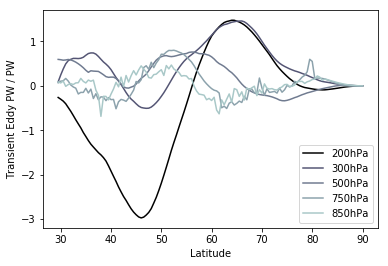

In [8]:
    print ('***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********')
    print ('=====   p 200 300 400 500 600 750 850 eddy transient zonal + winter (DJF)   ======')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    p200_eddy_season_series = meta.statistics.operator.seasons(p200_transient_zonal_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p200_eddy = meta.statistics.operator(p200_eddy_season_series[3:,:])
    stat_p200_eddy.anomaly(Dim_month=False)
    stat_p200_eddy.detrend()
    stat_p200_eddy.lowpass(window=30, obj='detrend')
    k_p200, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                          stat_p200_eddy._lowpass)
    p300_eddy_season_series = meta.statistics.operator.seasons(p300_transient_zonal_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p300_eddy = meta.statistics.operator(p300_eddy_season_series[3:,:])
    stat_p300_eddy.anomaly(Dim_month=False)
    stat_p300_eddy.detrend()
    stat_p300_eddy.lowpass(window=30, obj='detrend')
    k_p300, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                          stat_p300_eddy._lowpass)
#     p400_eddy_season_series = meta.statistics.operator.seasons(p400_transient_zonal_weight[:],
#                                                                span=lag_winter[lag], Dim_month=True)
#     stat_p400_eddy = meta.statistics.operator(p400_eddy_season_series[3:,:])
#     stat_p400_eddy.anomaly(Dim_month=False)
#     stat_p400_eddy.detrend()
#     stat_p400_eddy.lowpass(window=30, obj='detrend')
#     k_p400, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
#                                                           stat_p400_eddy._lowpass)
    p500_eddy_season_series = meta.statistics.operator.seasons(p500_transient_zonal_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p500_eddy = meta.statistics.operator(p500_eddy_season_series[3:,:])
    stat_p500_eddy.anomaly(Dim_month=False)
    stat_p500_eddy.detrend()
    stat_p500_eddy.lowpass(window=30, obj='detrend')
    k_p500, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                          stat_p500_eddy._lowpass)
#     p600_eddy_season_series = meta.statistics.operator.seasons(p600_transient_zonal_weight[:],
#                                                                span=lag_winter[lag], Dim_month=True)
#     stat_p600_eddy = meta.statistics.operator(p600_eddy_season_series[3:,:])
#     stat_p600_eddy.anomaly(Dim_month=False)
#     stat_p600_eddy.detrend()
#     stat_p600_eddy.lowpass(window=30, obj='detrend')
#     k_p600, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
#                                                           stat_p600_eddy._lowpass)
    p750_eddy_season_series = meta.statistics.operator.seasons(p750_transient_zonal_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p750_eddy = meta.statistics.operator(p750_eddy_season_series[3:,:])
    stat_p750_eddy.anomaly(Dim_month=False)
    stat_p750_eddy.detrend()
    stat_p750_eddy.lowpass(window=30, obj='detrend')
    k_p750, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                          stat_p750_eddy._lowpass)
    p850_eddy_season_series = meta.statistics.operator.seasons(p850_transient_zonal_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p850_eddy = meta.statistics.operator(p850_eddy_season_series[3:,:])
    stat_p850_eddy.anomaly(Dim_month=False)
    stat_p850_eddy.detrend()
    stat_p850_eddy.lowpass(window=30, obj='detrend')
    k_p850, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                          stat_p850_eddy._lowpass)
    fig = plt.figure()
    colormap=cm.bone(np.linspace(0,1,9))
    # there is a bug for the E eddy decomposition
    # g has been divided by each variable
    # we should compensate it here
    plt.plot(latitude_eddy_MERRA2[58:], k_p200[58:] * 150 * 100 / constant['g'] * 480 / 1E+15, color=colormap[0], label='200hPa')
    plt.plot(latitude_eddy_MERRA2[58:], k_p300[58:] * 150 * 100 / constant['g'] * 480 / 1E+15, color=colormap[3], label='300hPa')
    #plt.plot(latitude_eddy, k_p400 * constant['cp'] * (level[19]-level[18]) * 100 / constant['g'] * 480 / 1E+15, label='400hPa)
    plt.plot(latitude_eddy_MERRA2[58:], k_p500[58:] * 225 * 100 / constant['g'] * 480 / 1E+15, color=colormap[4], label='500hPa')
    #plt.plot(latitude_eddy, k_p600 * constant['cp'] * (level[23]-level[22]) * 100 / constant['g'] * 480 / 1E+15, label='600hPa')
    plt.plot(latitude_eddy_MERRA2[58:], k_p750[58:] * 175 * 100 / constant['g'] * 480 / 1E+15,color=colormap[5], label='750hPa')
    plt.plot(latitude_eddy_MERRA2[58:], k_p850[58:] * 125 * 100 / constant['g'] * 480 / 1E+15,color=colormap[6], label='850hPa')
    plt.xlabel("Latitude")
    plt.legend()
    plt.ylabel("Transient Eddy PW / PW")
    plt.show()
    fig.savefig(os.path.join(output_path,'regCoef_ORAS4_atl_OMET_60N_lag_{}_MERRA2_eddy_E_transient_zonal_DJF_decadal_mean.png'.format(lag)),dpi=150)
    plt.close(fig)

***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********
=====   p 200 300 400 500 600 750 850 eddy standing zonal + winter (DJF)   ======
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 1D field.
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 1D field.
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 1D field.
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 1D field.
The input data does not have the dimension of mon

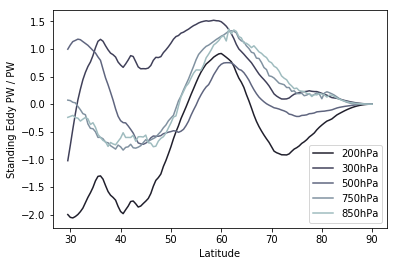

In [9]:
    print ('***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********')
    print ('=====   p 200 300 400 500 600 750 850 eddy standing zonal + winter (DJF)   ======')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    p200_eddy_season_series = meta.statistics.operator.seasons(p200_standing_zonal_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p200_eddy = meta.statistics.operator(p200_eddy_season_series[3:,:])
    stat_p200_eddy.anomaly(Dim_month=False)
    stat_p200_eddy.detrend()
    stat_p200_eddy.lowpass(window=30, obj='detrend')
    k_p200, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                          stat_p200_eddy._lowpass)
    p300_eddy_season_series = meta.statistics.operator.seasons(p300_standing_zonal_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p300_eddy = meta.statistics.operator(p300_eddy_season_series[3:,:])
    stat_p300_eddy.anomaly(Dim_month=False)
    stat_p300_eddy.detrend()
    stat_p300_eddy.lowpass(window=30, obj='detrend')
    k_p300, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                          stat_p300_eddy._lowpass)
#     p400_eddy_season_series = meta.statistics.operator.seasons(p400_standing_zonal_weight[:],
#                                                                span=lag_winter[lag], Dim_month=True)
#     stat_p400_eddy_ERAI = meta.statistics.operator(p400_eddy_season_series[3:,:])
#     stat_p400_eddy_ERAI.anomaly(Dim_month=False)
#     stat_p400_eddy_ERAI.detrend()
#     stat_p400_eddy_ERAI.lowpass(window=30, obj='detrend')
#     k_p400, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
#                                                           stat_p400_eddy_ERAI._lowpass)
    p500_eddy_season_series = meta.statistics.operator.seasons(p500_standing_zonal_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p500_eddy = meta.statistics.operator(p500_eddy_season_series[3:,:])
    stat_p500_eddy.anomaly(Dim_month=False)
    stat_p500_eddy.detrend()
    stat_p500_eddy.lowpass(window=30, obj='detrend')
    k_p500, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                          stat_p500_eddy._lowpass)
#     p600_eddy_season_series = meta.statistics.operator.seasons(p600_standing_zonal_weight[:],
#                                                                span=lag_winter[lag], Dim_month=True)
#     stat_p600_eddy_ERAI = meta.statistics.operator(p600_eddy_season_series[3:,:])
#     stat_p600_eddy_ERAI.anomaly(Dim_month=False)
#     stat_p600_eddy_ERAI.detrend()
#     stat_p600_eddy_ERAI.lowpass(window=30, obj='detrend')
#     k_p600, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
#                                                           stat_p600_eddy_ERAI._lowpass)
    p750_eddy_season_series = meta.statistics.operator.seasons(p750_standing_zonal_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p750_eddy = meta.statistics.operator(p750_eddy_season_series[3:,:])
    stat_p750_eddy.anomaly(Dim_month=False)
    stat_p750_eddy.detrend()
    stat_p750_eddy.lowpass(window=30, obj='detrend')
    k_p750, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                          stat_p750_eddy._lowpass)
    p850_eddy_season_series = meta.statistics.operator.seasons(p850_standing_zonal_weight[:],
                                                               span=lag_winter[lag], Dim_month=True)
    stat_p850_eddy = meta.statistics.operator(p850_eddy_season_series[3:,:])
    stat_p850_eddy.anomaly(Dim_month=False)
    stat_p850_eddy.detrend()
    stat_p850_eddy.lowpass(window=30, obj='detrend')
    k_p850, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                          stat_p850_eddy._lowpass)
    fig = plt.figure()
    # there is a bug for the E eddy decomposition
    # g has been divided by each variable
    # we should compensate it here
    colormap=cm.bone(np.linspace(0,1,8))
    plt.plot(latitude_eddy_MERRA2[58:], k_p200[58:] * 150 * 100 / constant['g'] * 480 / 1E+15, color=colormap[1], label='200hPa')
    plt.plot(latitude_eddy_MERRA2[58:], k_p300[58:] * 150 * 100 / constant['g'] * 480 / 1E+15, color=colormap[2], label='300hPa')
    #plt.plot(latitude_eddy_ERAI, k_p400 * (level[19]-level[18]) * 100 / constant['g'] * 480 / 1E+15, color=colormap[1], label='400hPa')
    plt.plot(latitude_eddy_MERRA2[58:], k_p500[58:] * 225 * 100 / constant['g'] * 480 / 1E+15, color=colormap[3], label='500hPa')
    #plt.plot(latitude_eddy_ERAI, k_p600 * ? * 100 / constant['g'] * 480 / 1E+15, color=colormap[1], label='600hPa')
    plt.plot(latitude_eddy_MERRA2[58:], k_p750[58:] * 175 * 100 / constant['g'] * 480 / 1E+15, color=colormap[4], label='750hPa')
    plt.plot(latitude_eddy_MERRA2[58:], k_p850[58:] * 125 * 100 / constant['g'] * 480 / 1E+15, color=colormap[5], label='850hPa')
    plt.xlabel("Latitude")
    plt.legend()
    plt.ylabel("Standing Eddy PW / PW")
    plt.show()
    fig.savefig(os.path.join(output_path,'regCoef_ORAS4_atl_OMET_60N_lag_{}_MERRA2_eddy_E_standing_zonal_DJF_decadal_mean.png'.format(lag)),dpi=150)
    plt.close(fig)

***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********
=====   p 200 300 400 500 600 750 850 steady mean flow zonal + winter (DJF)   ======
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st, vice versa.


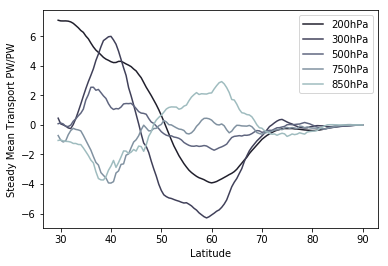

In [21]:
    print ('***********!@#$%^&*     Vertical Profile of zonal mean eddies   !@#$%^&***********')
    print ('=====   p 200 300 400 500 600 750 850 steady mean flow zonal + winter (DJF)   ======')
    lag = 1
    OMET_season_series = meta.statistics.operator.seasons(OMET_atl_int_ORAS4[:,:,53],
                                                          span='DJF', Dim_month=True)    
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_season_series[2:-1])
    stat_OMET_ORAS4.anomaly(Dim_month=False)
    stat_OMET_ORAS4.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_OMET_ORAS4.lowpass(window=30, obj='detrend')
    E_vert_season_series = meta.statistics.operator.seasons(E_vert[:],
                                                            span=lag_winter[lag], Dim_month=True)
    stat_E_vert_MERRA2 = meta.statistics.operator(E_vert_season_series[3:])
    stat_E_vert_MERRA2.anomaly(Dim_month=False)
    stat_E_vert_MERRA2.detrend()
    stat_E_vert_MERRA2.lowpass(window=30, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_OMET_ORAS4._lowpass,
                                                     stat_E_vert_MERRA2._lowpass, lag)
    
    fig = plt.figure()
    colormap=cm.bone(np.linspace(0,1,8))
    plt.plot(latitude_fields_vert_MERRA2[239:], np.mean(k[17:20,239:],0), color=colormap[1], label='200hPa') # 100 - 250
    plt.plot(latitude_fields_vert_MERRA2[239:], np.mean(k[20:23,239:],0), color=colormap[2], label='300hPa') # 250 - 400
    #plt.plot(latitude_fields_vert_ERAI[:94], k[19,:94], color=colormap[6], label='400hPa')
    plt.plot(latitude_fields_vert_MERRA2[239:], np.mean(k[23:28,239:],0), color=colormap[3], label='500hPa') # 400 - 650
    #plt.plot(latitude_fields_vert_ERAI[:94], k[23,:94], color=colormap[6], label='600hPa')
    plt.plot(latitude_fields_vert_MERRA2[239:], np.mean(k[28:33,239:],0), color=colormap[4], label='750hPa') # 650 - 800
    plt.plot(latitude_fields_vert_MERRA2[239:], np.mean(k[33:37,239:],0), color=colormap[5], label='850hPa') # 800 - 900
    plt.xlabel("Latitude")
    plt.legend()
    plt.ylabel("Steady Mean Transport PW/PW")
    plt.show()
    fig.savefig(os.path.join(output_path,'regCoef_ORAS4_atl_OMET_60N_lag_{}_MERRA2_eddy_E_steady_mean_DJF_decadal_mean.png'.format(lag)),dpi=150)
    plt.close(fig)

In [20]:
print(latitude_fields_vert_MERRA2[239:])

[29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5 35.  35.5 36.
 36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5 42.  42.5 43.
 43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5 49.  49.5 50.
 50.5 51.  51.5 52.  52.5 53.  53.5 54.  54.5 55.  55.5 56.  56.5 57.
 57.5 58.  58.5 59.  59.5 60.  60.5 61.  61.5 62.  62.5 63.  63.5 64.
 64.5 65.  65.5 66.  66.5 67.  67.5 68.  68.5 69.  69.5 70.  70.5 71.
 71.5 72.  72.5 73.  73.5 74.  74.5 75.  75.5 76.  76.5 77.  77.5 78.
 78.5 79.  79.5 80.  80.5 81.  81.5 82.  82.5 83.  83.5 84.  84.5 85.
 85.5 86.  86.5 87.  87.5 88.  88.5 89.  89.5 90. ]


==========================================================================<br>
Below the figures are for diagnostic only. They are aiming for the review.<br>
==========================================================================<br>

In [34]:
print(level[26])

750


***********!@#$%^&*     Vertical Profile of all the components   !@#$%^&***********
=====   p 200 500 850 climatology of steady mean / transient & standing eddies  ======
=====                         mass weight by single layer                       ======


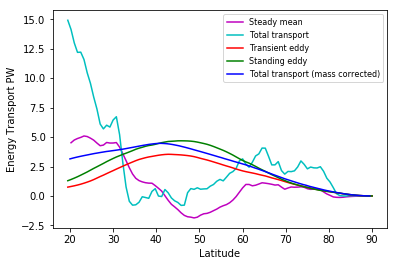

In [7]:
    print ('***********!@#$%^&*     Vertical Profile of all the components   !@#$%^&***********')
    print ('=====   p 200 500 850 climatology of steady mean / transient & standing eddies  ======')
    print ('=====                         mass weight by single layer                       ======')
    #E_vert_clim = np.mean(np.mean(E_vert[:],0),0)
    p200_steady_mean_clim = np.mean(np.mean(E_vert[:,:,14,:],0),0)
    p300_steady_mean_clim = np.mean(np.mean(E_vert[:,:,17,:],0),0)
    p400_steady_mean_clim = np.mean(np.mean(E_vert[:,:,19,:],0),0)
    p500_steady_mean_clim = np.mean(np.mean(E_vert[:,:,21,:],0),0)
    p600_steady_mean_clim = np.mean(np.mean(E_vert[:,:,23,:],0),0)
    p750_steady_mean_clim = np.mean(np.mean(E_vert[:,:,25,:],0),0)
    p850_steady_mean_clim = np.mean(np.mean(E_vert[:,:,26,:],0),0)
    
    p200_transient_clim = np.mean(np.mean(p200_transient_zonal_weight[:],0),0)\
                          * (level[14]) * 100 / constant['g'] * 480 / 1E+15
    p300_transient_clim = np.mean(np.mean(p300_transient_zonal_weight[:],0),0)\
                          * (level[17] - level[14]) * 100 / constant['g'] * 480 / 1E+15
    p400_transient_clim = np.mean(np.mean(p400_transient_zonal_weight[:],0),0)\
                          * (level[19] - level[17]) * 100 / constant['g'] * 480 / 1E+15
    p500_transient_clim = np.mean(np.mean(p500_transient_zonal_weight[:],0),0)\
                          * (level[21] - level[19]) * 100 / constant['g'] * 480 / 1E+15
    p600_transient_clim = np.mean(np.mean(p600_transient_zonal_weight[:],0),0)\
                          * (level[23] - level[21]) * 100 / constant['g'] * 480 / 1E+15
    p750_transient_clim = np.mean(np.mean(p750_transient_zonal_weight[:],0),0)\
                          * (level[26] - level[23]) * 100 / constant['g'] * 480 / 1E+15
    p850_transient_clim = np.mean(np.mean(p850_transient_zonal_weight[:],0),0)\
                          * (level[-1] - level[26]) * 100 / constant['g'] * 480 / 1E+15
    
    p200_standing_clim = np.mean(np.mean(p200_standing_zonal_weight[:],0),0)\
                          * (level[14]) * 100 / constant['g'] * 480 / 1E+15
    p300_standing_clim = np.mean(np.mean(p300_standing_zonal_weight[:],0),0)\
                          * (level[17] - level[14]) * 100 / constant['g'] * 480 / 1E+15
    p400_standing_clim = np.mean(np.mean(p400_standing_zonal_weight[:],0),0)\
                          * (level[19] - level[17]) * 100 / constant['g'] * 480 / 1E+15
    p500_standing_clim = np.mean(np.mean(p500_standing_zonal_weight[:],0),0)\
                          * (level[21] - level[19]) * 100 / constant['g'] * 480 / 1E+15
    p600_standing_clim = np.mean(np.mean(p600_standing_zonal_weight[:],0),0)\
                          * (level[23] - level[21]) * 100 / constant['g'] * 480 / 1E+15
    p750_standing_clim = np.mean(np.mean(p750_standing_zonal_weight[:],0),0)\
                          * (level[26] - level[23]) * 100 / constant['g'] * 480 / 1E+15
    p850_standing_clim = np.mean(np.mean(p850_standing_zonal_weight[:],0),0)\
                          * (level[-1] - level[26]) * 100 / constant['g'] * 480 / 1E+15
    
    p200_overall_clim = np.mean(np.mean(p200_overall_zonal_weight[:],0),0)\
                          * (level[14]) * 100 / constant['g'] * 480 / 1E+15
    p300_overall_clim = np.mean(np.mean(p300_overall_zonal_weight[:],0),0)\
                          * (level[17] - level[14]) * 100 / constant['g'] * 480 / 1E+15
    p400_overall_clim = np.mean(np.mean(p400_overall_zonal_weight[:],0),0)\
                          * (level[19] - level[17]) * 100 / constant['g'] * 480 / 1E+15
    p500_overall_clim = np.mean(np.mean(p500_overall_zonal_weight[:],0),0)\
                          * (level[21] - level[19]) * 100 / constant['g'] * 480 / 1E+15
    p600_overall_clim = np.mean(np.mean(p600_overall_zonal_weight[:],0),0)\
                          * (level[23] - level[21]) * 100 / constant['g'] * 480 / 1E+15
    p750_overall_clim = np.mean(np.mean(p750_overall_zonal_weight[:],0),0)\
                          * (level[26] - level[23]) * 100 / constant['g'] * 480 / 1E+15
    p850_overall_clim = np.mean(np.mean(p850_overall_zonal_weight[:],0),0)\
                          * (level[-1] - level[26]) * 100 / constant['g'] * 480 / 1E+15    
    
    steady_mean_clim = p200_steady_mean_clim + p300_steady_mean_clim + p400_steady_mean_clim +\
                     p500_steady_mean_clim + p600_steady_mean_clim + p750_steady_mean_clim + p850_steady_mean_clim    
    transient_clim = p200_transient_clim + p300_transient_clim + p400_transient_clim +\
                     p500_transient_clim + p600_transient_clim + p750_transient_clim + p850_transient_clim
    standing_clim = p200_standing_clim + p300_standing_clim + p400_standing_clim +\
                    p500_standing_clim + p600_standing_clim + p750_standing_clim + p850_standing_clim
    overall_clim = p200_overall_clim + p300_overall_clim + p400_overall_clim +\
                    p500_overall_clim + p600_overall_clim + p750_overall_clim + p850_overall_clim
    
    fig = plt.figure()
    #plt.plot(latitude_fields_vert_ERAI[:94], np.sum(E_vert_clim[:,:94],0), 'm-', label='Steady mean')
    plt.plot(latitude_fields_vert_ERAI[:94], steady_mean_clim[:94], 'm-', label='Steady mean')
    plt.plot(latitude_eddy_ERAI, overall_clim, 'c-', label='Total transport')
    plt.plot(latitude_eddy_ERAI, transient_clim, 'r-', label='Transient eddy')
    plt.plot(latitude_eddy_ERAI, standing_clim, 'g-', label='Standing eddy')
    plt.plot(ERAI_AMET_lat,np.mean(np.mean(ERAI_AMET[:],0),0),'b-', label='Total transport (mass corrected)')
    plt.xlabel("Latitude")
    plt.legend(loc=1,prop={'size': 8})
    plt.ylabel("Energy Transport PW")
    plt.show()
    fig.savefig(os.path.join(output_path, 'climatology',
                             'ERAI_eddy_E_climatology_column.png'),dpi=200)
    plt.close(fig)
    
#     fig = plt.figure()
#     plt.plot(latitude_fields_vert_ERAI[:54], E_vert_clim[14,:54], 'b-', label='Steady mean 200hPa')
#     plt.plot(latitude_fields_vert_ERAI[:54], E_vert_clim[21,:54], 'b--', label='Steady mean 500hPa')
#     plt.plot(latitude_fields_vert_ERAI[:54], E_vert_clim[30,:54], 'b:', label='Steady mean 850hPa')
#     plt.plot(latitude_eddy_ERAI[:54], p200_transient_clim[:54],'r-', label='Transient eddy 200hPa')
#     plt.plot(latitude_eddy_ERAI[:54], p200_transient_clim_mm[:54],'m-', label='Transient eddy 200hPa (mm)')
#     plt.plot(latitude_eddy_ERAI[:54], p500_transient_clim[:54],'r--', label='Transient eddy 500hPa')
#     plt.plot(latitude_eddy_ERAI[:54], p850_transient_clim[:54],'r:', label='Transient eddy 850hPa')
#     plt.plot(latitude_eddy_ERAI[:54], p200_standing_clim[:54],'g-', label='Standing eddy 200hPa')
#     plt.plot(latitude_eddy_ERAI[:54], p200_standing_clim_mm[:54],'y-', label='Standing eddy 200hPa (mm)')
#     plt.plot(latitude_eddy_ERAI[:54], p500_standing_clim[:54],'g--', label='Standing eddy 500hPa')
#     plt.plot(latitude_eddy_ERAI[:54], p850_standing_clim[:54],'g:', label='Standing eddy 850hPa')
    
#     plt.xlabel("Latitude")
#     plt.legend(loc=1,prop={'size': 8})
#     plt.ylabel("Energy Transport PW")
#     plt.show()
#     fig.savefig(os.path.join(output_path, 'climatology',
#                              'ERAI_eddy_E_climatology_50-90N_column.png'),dpi=200)
#     plt.close(fig)    

***********!@#$%^&*     Vertical Profile of all the components   !@#$%^&***********
=====   p 200 500 850 steady mean / transient & standing eddies  ======


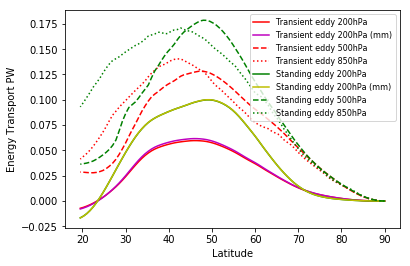

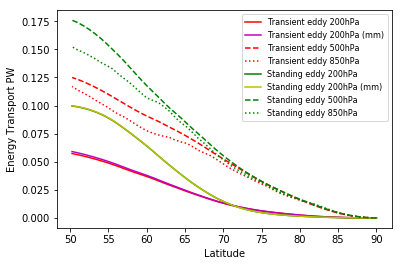

In [8]:
    print ('***********!@#$%^&*     Vertical Profile of all the components   !@#$%^&***********')
    print ('=====   p 200 500 850 climatology of transient & standing eddies  ======')
    print ('=====                         mass weight by single layer                       ======')
    E_vert_clim = np.mean(np.mean(E_vert[:],0),0)
    p200_transient_clim = np.mean(np.mean(p200_transient_zonal_weight[:],0),0)\
                          * (level[14]-level[13]) * 100 / constant['g'] * 480 / 1E+15
    p200_transient_clim_mm = np.mean(np.mean(p200_transient_zonal_weight_mm[:],0),0)\
                          * (level[14]-level[13]) * 100 / constant['g'] * 480 / 1E+15
    p500_transient_clim = np.mean(np.mean(p500_transient_zonal_weight[:],0),0)\
                          * (level[21]-level[20]) * 100 / constant['g'] * 480 / 1E+15
    p850_transient_clim = np.mean(np.mean(p850_transient_zonal_weight[:],0),0)\
                          * (level[30]-level[29]) * 100 / constant['g'] * 480 / 1E+15
    p200_standing_clim = np.mean(np.mean(p200_standing_zonal_weight[:],0),0)\
                          * (level[14]-level[13]) * 100 / constant['g'] * 480 / 1E+15
    p200_standing_clim_mm = np.mean(np.mean(p200_standing_zonal_weight_mm[:],0),0)\
                          * (level[14]-level[13]) * 100 / constant['g'] * 480 / 1E+15
    p500_standing_clim = np.mean(np.mean(p500_standing_zonal_weight[:],0),0)\
                          * (level[21]-level[20]) * 100 / constant['g'] * 480 / 1E+15
    p850_standing_clim = np.mean(np.mean(p850_standing_zonal_weight[:],0),0)\
                          * (level[30]-level[29]) * 100 / constant['g'] * 480 / 1E+15
    fig = plt.figure()
    #plt.plot(latitude_fields_vert_ERAI[:94], E_vert_clim[14,:94], 'b-', label='Steady mean 200hPa')
    #plt.plot(latitude_fields_vert_ERAI[:94], E_vert_clim[21,:94], 'b--', label='Steady mean 500hPa')
    #plt.plot(latitude_fields_vert_ERAI[:94], E_vert_clim[30,:94], 'b:', label='Steady mean 850hPa')
    plt.plot(latitude_eddy_ERAI, p200_transient_clim,'r-', label='Transient eddy 200hPa')
    plt.plot(latitude_eddy_ERAI, p200_transient_clim_mm,'m-', label='Transient eddy 200hPa (mm)')
    plt.plot(latitude_eddy_ERAI, p500_transient_clim,'r--', label='Transient eddy 500hPa')
    plt.plot(latitude_eddy_ERAI, p850_transient_clim,'r:', label='Transient eddy 850hPa')
    plt.plot(latitude_eddy_ERAI, p200_standing_clim,'g-', label='Standing eddy 200hPa')
    plt.plot(latitude_eddy_ERAI, p200_standing_clim_mm,'y-', label='Standing eddy 200hPa (mm)')
    plt.plot(latitude_eddy_ERAI, p500_standing_clim,'g--', label='Standing eddy 500hPa')
    plt.plot(latitude_eddy_ERAI, p850_standing_clim,'g:', label='Standing eddy 850hPa')
    
    plt.xlabel("Latitude")
    plt.legend(loc=1,prop={'size': 8})
    plt.ylabel("Energy Transport PW")
    plt.show()
    fig.savefig(os.path.join(output_path, 'climatology',
                             'ERAI_eddy_E_climatology_EddyOnly.png'),dpi=200)
    plt.close(fig)
    
    fig = plt.figure()
    #plt.plot(latitude_fields_vert_ERAI[:54], E_vert_clim[14,:54], 'b-', label='Steady mean 200hPa')
    #plt.plot(latitude_fields_vert_ERAI[:54], E_vert_clim[21,:54], 'b--', label='Steady mean 500hPa')
    #plt.plot(latitude_fields_vert_ERAI[:54], E_vert_clim[30,:54], 'b:', label='Steady mean 850hPa')
    plt.plot(latitude_eddy_ERAI[:54], p200_transient_clim[:54],'r-', label='Transient eddy 200hPa')
    plt.plot(latitude_eddy_ERAI[:54], p200_transient_clim_mm[:54],'m-', label='Transient eddy 200hPa (mm)')
    plt.plot(latitude_eddy_ERAI[:54], p500_transient_clim[:54],'r--', label='Transient eddy 500hPa')
    plt.plot(latitude_eddy_ERAI[:54], p850_transient_clim[:54],'r:', label='Transient eddy 850hPa')
    plt.plot(latitude_eddy_ERAI[:54], p200_standing_clim[:54],'g-', label='Standing eddy 200hPa')
    plt.plot(latitude_eddy_ERAI[:54], p200_standing_clim_mm[:54],'y-', label='Standing eddy 200hPa (mm)')
    plt.plot(latitude_eddy_ERAI[:54], p500_standing_clim[:54],'g--', label='Standing eddy 500hPa')
    plt.plot(latitude_eddy_ERAI[:54], p850_standing_clim[:54],'g:', label='Standing eddy 850hPa')
    
    plt.xlabel("Latitude")
    plt.legend(loc=1,prop={'size': 8})
    plt.ylabel("Energy Transport PW")
    plt.show()
    fig.savefig(os.path.join(output_path, 'climatology',
                             'ERAI_eddy_E_climatology_50-90N_EddyOnly.png'),dpi=200)
    plt.close(fig)    

In [ ]:
    print ('***********!@#$%^&*     Vertical Profile of all the components   !@#$%^&***********')
    print ('=====   p 200 500 850 climatology of steady mean / transient & standing eddies  ======')
    print ('=====                      mass weight by whole column depth                    ======')
    E_vert_clim = np.mean(np.mean(E_vert[:],0),0)
    p200_transient_clim = np.mean(np.mean(p200_transient_zonal_weight[:],0),0)\
                          * (level[14]-level[13]) * 100 / constant['g'] * 480 / 1E+15
    p200_transient_clim_mm = np.mean(np.mean(p200_transient_zonal_weight_mm[:],0),0)\
                          * (level[14]-level[13]) * 100 / constant['g'] * 480 / 1E+15
    p500_transient_clim = np.mean(np.mean(p500_transient_zonal_weight[:],0),0)\
                          * (level[21]-level[20]) * 100 / constant['g'] * 480 / 1E+15
    p850_transient_clim = np.mean(np.mean(p850_transient_zonal_weight[:],0),0)\
                          * (level[30]-level[29]) * 100 / constant['g'] * 480 / 1E+15
    p200_standing_clim = np.mean(np.mean(p200_standing_zonal_weight[:],0),0)\
                          * (level[14]-level[13]) * 100 / constant['g'] * 480 / 1E+15
    p200_standing_clim_mm = np.mean(np.mean(p200_standing_zonal_weight_mm[:],0),0)\
                          * (level[14]-level[13]) * 100 / constant['g'] * 480 / 1E+15
    p500_standing_clim = np.mean(np.mean(p500_standing_zonal_weight[:],0),0)\
                          * (level[21]-level[20]) * 100 / constant['g'] * 480 / 1E+15
    p850_standing_clim = np.mean(np.mean(p850_standing_zonal_weight[:],0),0)\
                          * (level[30]-level[29]) * 100 / constant['g'] * 480 / 1E+15
    fig = plt.figure()
    plt.plot(latitude_fields_vert_ERAI[:94], E_vert_clim[14,:94], 'b-', label='Steady mean 200hPa')
    plt.plot(latitude_fields_vert_ERAI[:94], E_vert_clim[21,:94], 'b--', label='Steady mean 500hPa')
    plt.plot(latitude_fields_vert_ERAI[:94], E_vert_clim[30,:94], 'b:', label='Steady mean 850hPa')
    plt.plot(latitude_eddy_ERAI, p200_transient_clim,'r-', label='Transient eddy 200hPa')
    plt.plot(latitude_eddy_ERAI, p200_transient_clim_mm,'m-', label='Transient eddy 200hPa (mm)')
    plt.plot(latitude_eddy_ERAI, p500_transient_clim,'r--', label='Transient eddy 500hPa')
    plt.plot(latitude_eddy_ERAI, p850_transient_clim,'r:', label='Transient eddy 850hPa')
    plt.plot(latitude_eddy_ERAI, p200_standing_clim,'g-', label='Standing eddy 200hPa')
    plt.plot(latitude_eddy_ERAI, p200_standing_clim_mm,'y-', label='Standing eddy 200hPa (mm)')
    plt.plot(latitude_eddy_ERAI, p500_standing_clim,'g--', label='Standing eddy 500hPa')
    plt.plot(latitude_eddy_ERAI, p850_standing_clim,'g:', label='Standing eddy 850hPa')
    
    plt.xlabel("Latitude")
    plt.legend(loc=1,prop={'size': 8})
    plt.ylabel("Energy Transport PW")
    plt.show()
    fig.savefig(os.path.join(output_path, 'climatology',
                             'ERAI_eddy_E_climatology_all.png'),dpi=200)
    plt.close(fig)
    
    fig = plt.figure()
    plt.plot(latitude_fields_vert_ERAI[:54], E_vert_clim[14,:54], 'b-', label='Steady mean 200hPa')
    plt.plot(latitude_fields_vert_ERAI[:54], E_vert_clim[21,:54], 'b--', label='Steady mean 500hPa')
    plt.plot(latitude_fields_vert_ERAI[:54], E_vert_clim[30,:54], 'b:', label='Steady mean 850hPa')
    plt.plot(latitude_eddy_ERAI[:54], p200_transient_clim[:54],'r-', label='Transient eddy 200hPa')
    plt.plot(latitude_eddy_ERAI[:54], p200_transient_clim_mm[:54],'m-', label='Transient eddy 200hPa (mm)')
    plt.plot(latitude_eddy_ERAI[:54], p500_transient_clim[:54],'r--', label='Transient eddy 500hPa')
    plt.plot(latitude_eddy_ERAI[:54], p850_transient_clim[:54],'r:', label='Transient eddy 850hPa')
    plt.plot(latitude_eddy_ERAI[:54], p200_standing_clim[:54],'g-', label='Standing eddy 200hPa')
    plt.plot(latitude_eddy_ERAI[:54], p200_standing_clim_mm[:54],'y-', label='Standing eddy 200hPa (mm)')
    plt.plot(latitude_eddy_ERAI[:54], p500_standing_clim[:54],'g--', label='Standing eddy 500hPa')
    plt.plot(latitude_eddy_ERAI[:54], p850_standing_clim[:54],'g:', label='Standing eddy 850hPa')
    
    plt.xlabel("Latitude")
    plt.legend(loc=1,prop={'size': 8})
    plt.ylabel("Energy Transport PW")
    plt.show()
    fig.savefig(os.path.join(output_path, 'climatology',
                             'ERAI_eddy_E_climatology_50-90N.png'),dpi=200)
    plt.close(fig)    

***********!@#$%^&*     Vertical Profile of all the components   !@#$%^&***********
=====   p 200 500 850 steady mean / transient & standing eddies anomalies ======
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!


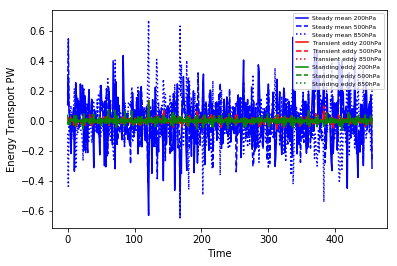

In [8]:
    print ('***********!@#$%^&*     Vertical Profile of all the components   !@#$%^&***********')
    print ('=====   p 200 500 850 steady mean / transient & standing eddies anomalies ======')  
    stat_steady_mean = meta.statistics.operator(E_vert[:])
    stat_steady_mean.anomaly(Dim_month=True)
    
    stat_transient_p200 = meta.statistics.operator(p200_transient_zonal_weight[:] * (level[14]-level[13])
                                                   * 100 / constant['g'] * 480 / 1E+15)
    stat_transient_p200.anomaly(Dim_month=True)
    
    stat_transient_p500 = meta.statistics.operator(p500_transient_zonal_weight[:] * (level[21]-level[20])
                                                   * 100 / constant['g'] * 480 / 1E+15)
    stat_transient_p500.anomaly(Dim_month=True)
    
    stat_transient_p850 = meta.statistics.operator(p850_transient_zonal_weight[:] * (level[30]-level[29])
                                                   * 100 / constant['g'] * 480 / 1E+15)
    stat_transient_p850.anomaly(Dim_month=True)
    
    stat_standing_p200 = meta.statistics.operator(p200_standing_zonal_weight[:] * (level[14]-level[13])
                                                   * 100 / constant['g'] * 480 / 1E+15)
    stat_standing_p200.anomaly(Dim_month=True)

    stat_standing_p500 = meta.statistics.operator(p500_standing_zonal_weight[:] * (level[21]-level[20])
                                                   * 100 / constant['g'] * 480 / 1E+15)
    stat_standing_p500.anomaly(Dim_month=True)

    stat_standing_p850 = meta.statistics.operator(p850_standing_zonal_weight[:] * (level[30]-level[29])
                                                   * 100 / constant['g'] * 480 / 1E+15)
    stat_standing_p850.anomaly(Dim_month=True)
    
    time_index = np.arange(len(year_eddy)*12)
    
    fig = plt.figure()
    plt.plot(time_index, stat_steady_mean._anomaly[:,14,40], 'b-', label='Steady mean 200hPa')
    plt.plot(time_index, stat_steady_mean._anomaly[:,21,40], 'b--', label='Steady mean 500hPa')
    plt.plot(time_index, stat_steady_mean._anomaly[:,30,40], 'b:', label='Steady mean 850hPa')
    plt.plot(time_index, stat_transient_p200._anomaly[:,40],'r-', label='Transient eddy 200hPa')
    plt.plot(time_index, stat_transient_p500._anomaly[:,40],'r--', label='Transient eddy 500hPa')
    plt.plot(time_index, stat_transient_p850._anomaly[:,40],'r:', label='Transient eddy 850hPa')
    plt.plot(time_index, stat_standing_p200._anomaly[:,40],'g-', label='Standing eddy 200hPa')
    plt.plot(time_index, stat_standing_p500._anomaly[:,40],'g--', label='Standing eddy 500hPa')
    plt.plot(time_index, stat_standing_p850._anomaly[:,40],'g:', label='Standing eddy 850hPa')
    
    plt.xlabel("Time")
    plt.legend(loc=1,prop={'size': 6})
    plt.ylabel("Energy Transport PW")
    plt.show()
    fig.savefig(os.path.join(output_path, 'climatology',
                             'ERAI_eddy_E_climatology_anomaly.png'),dpi=200)
    plt.close(fig)       

In [10]:
#print(stat_steady_mean._anomaly.shape)
print(latitude_eddy_ERAI[40])
print(level[14]-level[13])

60.0
25
